In [2]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import get_model_rocs, allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict, plot_losses
from nebula.models.neurlux import NeurLuxModel
from nebula.models.quovadis import QuoVadisModel
from nebula.models.dmds import DMDSGatedCNN
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ["nebula", "neurlux", "quovadis", "dmds"]
RUN_NAME = "speakeasy"

INFOLDER = "out_speakeasy"

RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]

NEBULA_VOCAB = 50000
NEURLUX_VOCAB = 10000
SEQ_LEN = 512
LIMIT = "full"

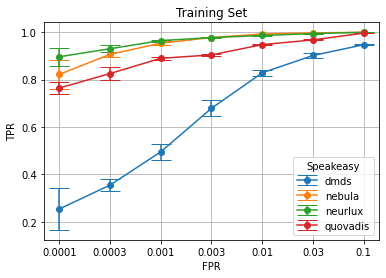

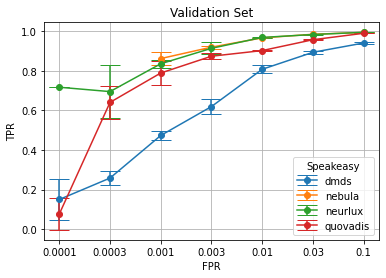

In [3]:
def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[0:1]

metrics_train = {}
metrics_val = {}
for folder in run_folders:
    metrics_train.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, training_filter))
    metrics_val.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, validation_filter))

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [4]:
models = defaultdict(dict)

nebula_vocab_file = os.path.join(INFOLDER, f"nebula_{RUN_NAME}_vocab_{NEBULA_VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{NEBULA_VOCAB}_vocab.json")
neurlux_vocab_file = os.path.join(INFOLDER, f"neurlux_{RUN_NAME}_vocab_{NEURLUX_VOCAB}_seqlen_{SEQ_LEN}", f"vocab_{NEURLUX_VOCAB}.json")

quo_vadis_data_folder = os.path.join(INFOLDER, f"quovadis_{RUN_NAME}_vocab_600_seqlen_{SEQ_LEN}")
quo_vadis_vocab_name = [x for x in os.listdir(quo_vadis_data_folder) if x.startswith("vocab")][0]
quovadis_vocab_file = os.path.join(quo_vadis_data_folder, quo_vadis_vocab_name)

with open(neurlux_vocab_file) as f:
    neurlux_vocab = json.load(f)
models['neurlux']['class'] = NeurLuxModel
models['neurlux']['config'] = {
    "embedding_dim": 256,
    "vocab_size": len(neurlux_vocab),
    "seq_len": SEQ_LEN,
}

models['quovadis']['class'] = QuoVadisModel
models['quovadis']['config'] = {
    "vocab": quovadis_vocab_file,
    "seq_len": SEQ_LEN
}

with open(nebula_vocab_file) as f:
    nebula_vocab = json.load(f)
models['nebula']['class'] = TransformerEncoderChunks
models['nebula']['config'] = {
    "vocab_size": len(nebula_vocab),
    "maxlen": SEQ_LEN,
    "chunk_size": 64,
    "dModel": 64,  # embedding & transformer dimension
    "nHeads": 8,  # number of heads in nn.MultiheadAttention
    "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
    "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    "numClasses": 1, # binary classification
    "hiddenNeurons": [64],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False,
    "norm_first": True
}

models['dmds']['class'] = DMDSGatedCNN
models['dmds']['config'] = {
    "ndim": 98,
    "seq_len": SEQ_LEN,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model_files = defaultdict(list)
metrics_val = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
        print(f"[!] Loaded: {key}")
    else:
        metrics = []
        print(f"[!] In process: {key}")

        folder = os.path.join(INFOLDER, folder)
        print(f"[*] Reading data splits from: {folder}")
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=64
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_val)

[!] Loaded: dmds
[!] Loaded: nebula
[!] In process: neurlux
[*] Reading data splits from: out_speakeasy\cv_neurlux_limNone_r1763_t5
[*] Running ROC for split: 0
Evaluating neurlux_split_0 | Size: 2794745...


100%|██████████| 397/397 [00:03<00:00, 104.99it/s]


[*] Running ROC for split: 1
Evaluating neurlux_split_1 | Size: 2794745...


100%|██████████| 397/397 [00:02<00:00, 135.53it/s]


[*] Running ROC for split: 2
Evaluating neurlux_split_2 | Size: 2794745...


100%|██████████| 397/397 [00:02<00:00, 132.63it/s]

[!] Loaded: quovadis


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
dmds,0.153990,0.270200,0.476728,0.619717,0.808046,0.894922,0.942644,0.991815,0.982715,0.941078,0.906657,0.978361,0.923324
nebula,0.235009,0.543692,0.851965,0.926304,0.966533,0.984413,0.994422,0.999125,0.997423,0.984811,0.982935,0.986698,0.979508
neurlux,0.537603,0.699828,0.836229,0.914644,0.968982,0.984257,0.994913,0.999242,0.997595,0.984755,0.979768,0.989805,0.979495
quovadis,0.078150,0.650227,0.789196,0.874130,0.924370,0.959923,0.991590,0.998950,0.995422,0.970978,0.954386,0.988188,0.961445


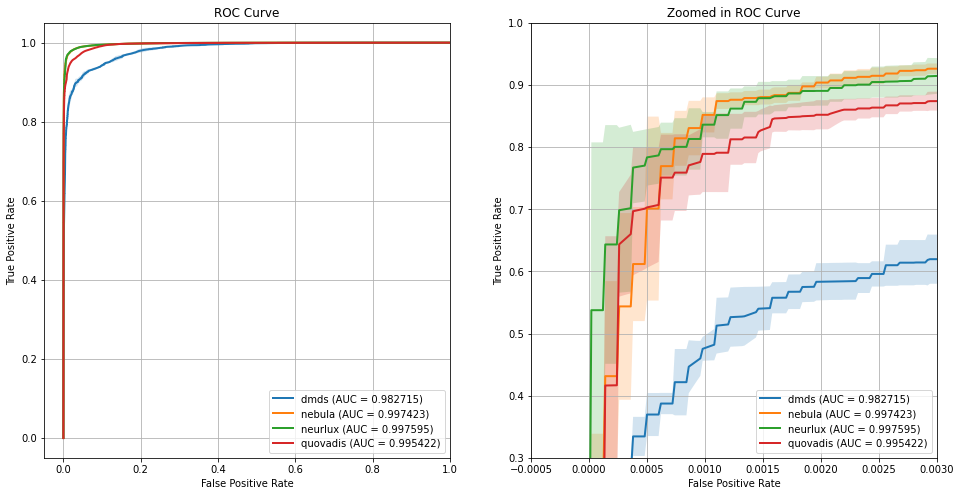

In [6]:
df, axs_val = report_alligned_metrics(
    base_fpr_val,
    tprs_mean_val,
    tprs_std_val,
    metrics_val,
    xlim=[-0.0005, 0.003],
    ylim=[0.3, 1.0],
    metrics_full=True
)
df

## Test set ROCs

In [7]:
model_files = defaultdict(list)
metrics_test = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = []
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        try:
            data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and "vocab" in x][0]
        except IndexError:
            data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and not x.endswith(".pkl")][0]
        print(f"[*] Reading data splits from: {data_folder}")
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))

        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true, y_pred, metrics_full=True)
            metrics.append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics

base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_test)

[*] In process: neurlux
[*] Reading data splits from: neurlux_speakeasy_vocab_10000_seqlen_512
[*] Running ROC for split: 0
Evaluating neurlux_split_0 | Size: 2794745...


100%|██████████| 182/182 [00:02<00:00, 82.68it/s]


[*] Running ROC for split: 1
Evaluating neurlux_split_1 | Size: 2794745...


100%|██████████| 182/182 [00:02<00:00, 89.33it/s]


[*] Running ROC for split: 2
Evaluating neurlux_split_2 | Size: 2794745...


100%|██████████| 182/182 [00:02<00:00, 87.75it/s]


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
dmds,0.104364,0.163423,0.215180,0.250948,0.274239,0.274522,0.600747,0.913148,0.887949,0.646453,0.508597,0.892643,0.701423
nebula,0.156581,0.338899,0.510972,0.620511,0.751959,0.835691,0.906058,0.959127,0.962754,0.897618,0.834911,0.970678,0.897206
neurlux,0.178595,0.241161,0.424971,0.498068,0.545854,0.683753,0.893945,0.948981,0.952849,0.879232,0.821759,0.946994,0.878631
quovadis,0.131554,0.232550,0.308129,0.338934,0.377539,0.474715,0.762714,0.951768,0.922398,0.806464,0.712397,0.934988,0.817257


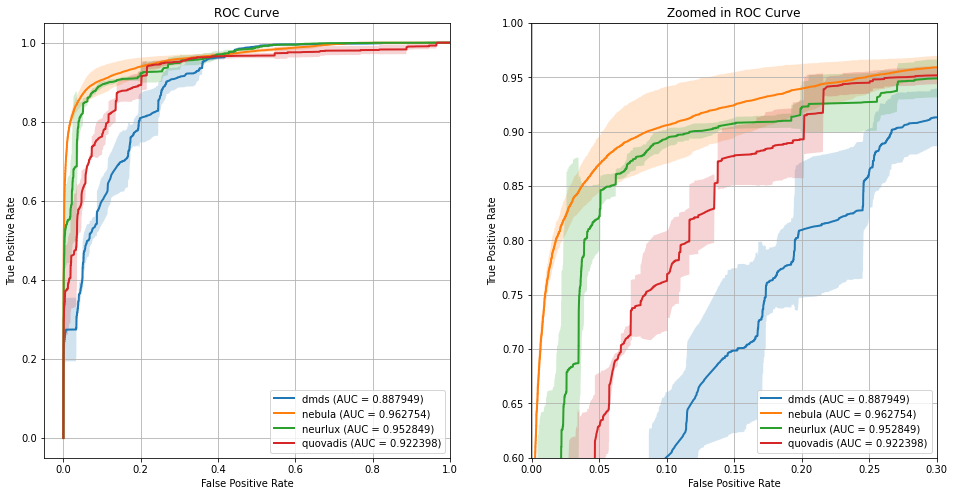

In [8]:
df, axs_test = report_alligned_metrics(
    base_fpr_test,
    tprs_mean_test,
    tprs_std_test,
    metrics_test,
    metrics_full=True
)
df

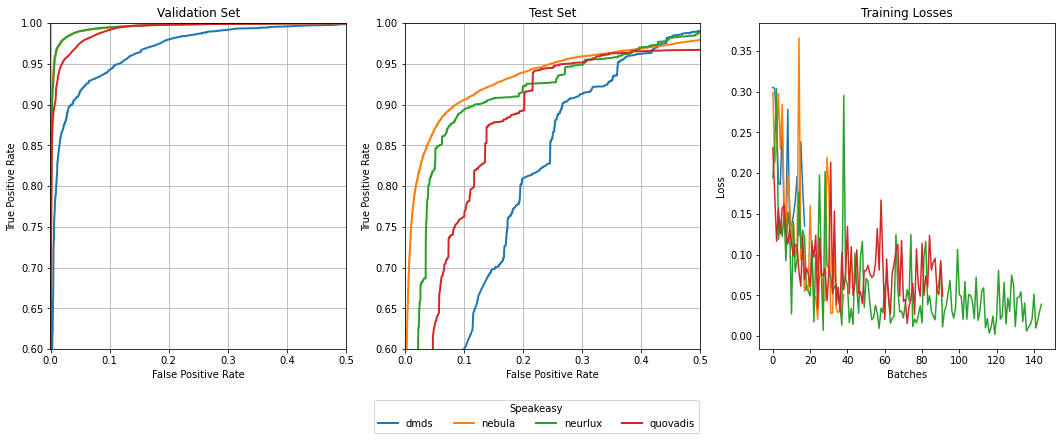

In [9]:
import matplotlib.pyplot as plt

YLIM = [0.6, 1]
XLIM = [-0.0005, 0.5]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 0.01:
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], model_name=key, ax=axs[0], ylim=YLIM, xlim=XLIM)
    plot_roc_curve(base_fpr_test, tprs_mean_test[key], model_name=key, ax=axs[1], ylim=YLIM, xlim=XLIM)

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

start = 200
n = 50
for folder in run_folders:
    key = folder.split("_")[1]
    train_folder = os.path.join(INFOLDER, folder, "training_files")
    train_losses = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if "trainLosses" in x][0]
    loss_mean = np.load(train_losses)[start::n]    
    axs[2].plot(loss_mean, label=key)
axs[2].set_xlabel("Batches")
axs[2].set_ylabel("Loss")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title=RUN_NAME.capitalize(), bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')